# NER - ES 

> Module to obtain the Entities

Article: Knowledge Graph – A Powerful Data Science Technique to Mine Information from Text (with Python code)

In [ ]:
#| default_exp ner

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#!python -m spacy download en_core_web_sm

In [ ]:
#import os

#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
#| export
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('./data/ES'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



./data/ES/duckduckgo_search.ddg_news_ucrania_20220928_213957.csv


In [ ]:
#nlp = spacy.load("es_core_news_sm")
nlp = spacy.load("es_dep_news_trf")

doc = nlp("Bruselas propone una nueva ronda de sanciones contra Rusia por la escalada en Ucrania y los referéndums")

for tok in doc:
    print(tok.text, "...", tok.dep_)



/Users/development/mambaforge/envs/fastai/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Bruselas ... nsubj
propone ... ROOT
una ... det
nueva ... amod
ronda ... obj
de ... case
sanciones ... nmod
contra ... case
Rusia ... nmod
por ... case
la ... det
escalada ... obl
en ... case
Ucrania ... nmod
y ... cc
los ... det
referéndums ... conj


In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load("es_dep_news_trf")

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("./data/ES/duckduckgo_search.ddg_news_ucrania_20220928_213957.csv")
candidate_sentences.drop(columns=['date','body','url','image','source'], inplace=True, axis=1)
candidate_sentences.rename(columns={"title": "sentence"}, inplace=True)

candidate_sentences.shape

(100, 1)

In [ ]:
candidate_sentences.head()

,sentence
0,Guerra en Ucrania: Analiza UE sanciones a Rusia por farsas en consultas
1,Regiones prorrusas de Ucrania piden ser parte de Rusia tras referendos cuestionados por Occidente
2,"Las fuerzas rusas organizaron ""referendos"" ilegales en Ucrania. ¿Qué sigue ahora?"
3,EEUU anuncia un nuevo paquete de ayuda militar a Ucrania de 1.100 millones
4,Ucrania pide más armas para responder a la anexión rusa de cuatro regiones ocupadas


In [ ]:
doc = nlp("Bruselas propone una nueva ronda de sanciones contra Rusia por la escalada en Ucrania y los referéndums")

for tok in doc:
    print(tok.text, "...", tok.dep_)


Bruselas ... nsubj
propone ... ROOT
una ... det
nueva ... amod
ronda ... obj
de ... case
sanciones ... nmod
contra ... case
Rusia ... nmod
por ... case
la ... det
escalada ... obl
en ... case
Ucrania ... nmod
y ... cc
los ... det
referéndums ... conj


/Users/development/mambaforge/envs/fastai/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
from spacy import displacy
displacy.render(doc, style="dep")

# Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.


In [ ]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("Bruselas propone una nueva ronda de sanciones contra Rusia por la escalada en Ucrania y los referéndums")

['Bruselas', '']

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.90it/s]


In [ ]:
entity_pairs[10:20]

[['Bruselas', ''],
 ['Ucrania  Comisión', ''],
 ['día  Sudán', ''],
 ['Ucrania', ''],
 ['iraníes  fabricados', ''],
 ['líderes', ''],
 ['Ucrania  PSOE', ''],
 ['Meloni', ''],
 ['rusa  que', ''],
 ['UE', '']]

## Relation / Predicate Extraction


In [ ]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [ ]:
get_relation("Bruselas propone una nueva ronda de sanciones contra Rusia por la escalada en Ucrania y los referéndums")

'propone'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.20it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

Guerra             6
pide               5
condena            5
asegura            4
dice               3
piden              3
considera          2
hora               2
prevé              2
denuncia           2
prepara            2
dispone            1
96%                1
recuerda           1
guerra             1
muere              1
advierte           1
Finaliza           1
descarta           1
donó               1
inspecciona        1
habrá              1
tilda              1
ratifica           1
sanciona           1
acusa              1
llegado            1
vuelve             1
funciona           1
emiten             1
llega              1
envía              1
apoya              1
donado             1
afirma             1
resultados         1
trabajó            1
precio             1
ultima             1
OTAN               1
Medios sociales    1
reconocerá         1
ofrece             1
plantea            1
0-0                1
sigue              1
anuncia            1
viviendo     

# Build the Knowledge Graph

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]
 
# extract object
target = [i[1] for i in entity_pairs]
 
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,,,Guerra
1,Regiones,,piden
2,ilegales Qué,,sigue
3,EEUU,,anuncia
4,Ucrania,,pide
...,...,...,...
95,Ucrania Zelenski,,funciona
96,en central,,vuelve
97,en inspectores,,llegado
98,en Zelenski,,acusa


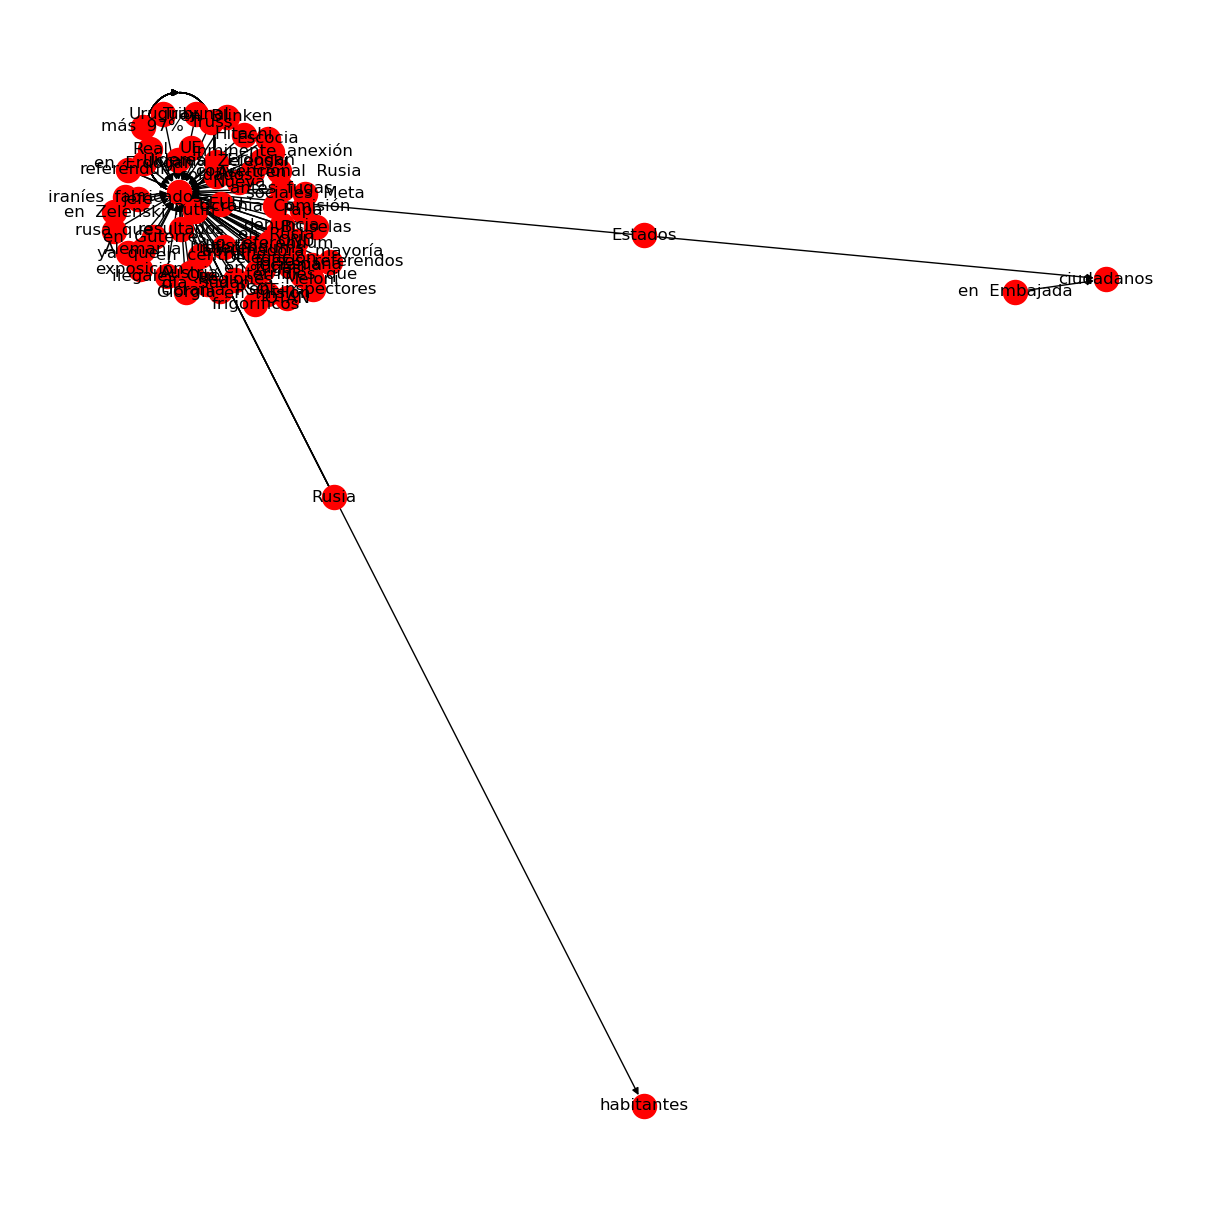

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

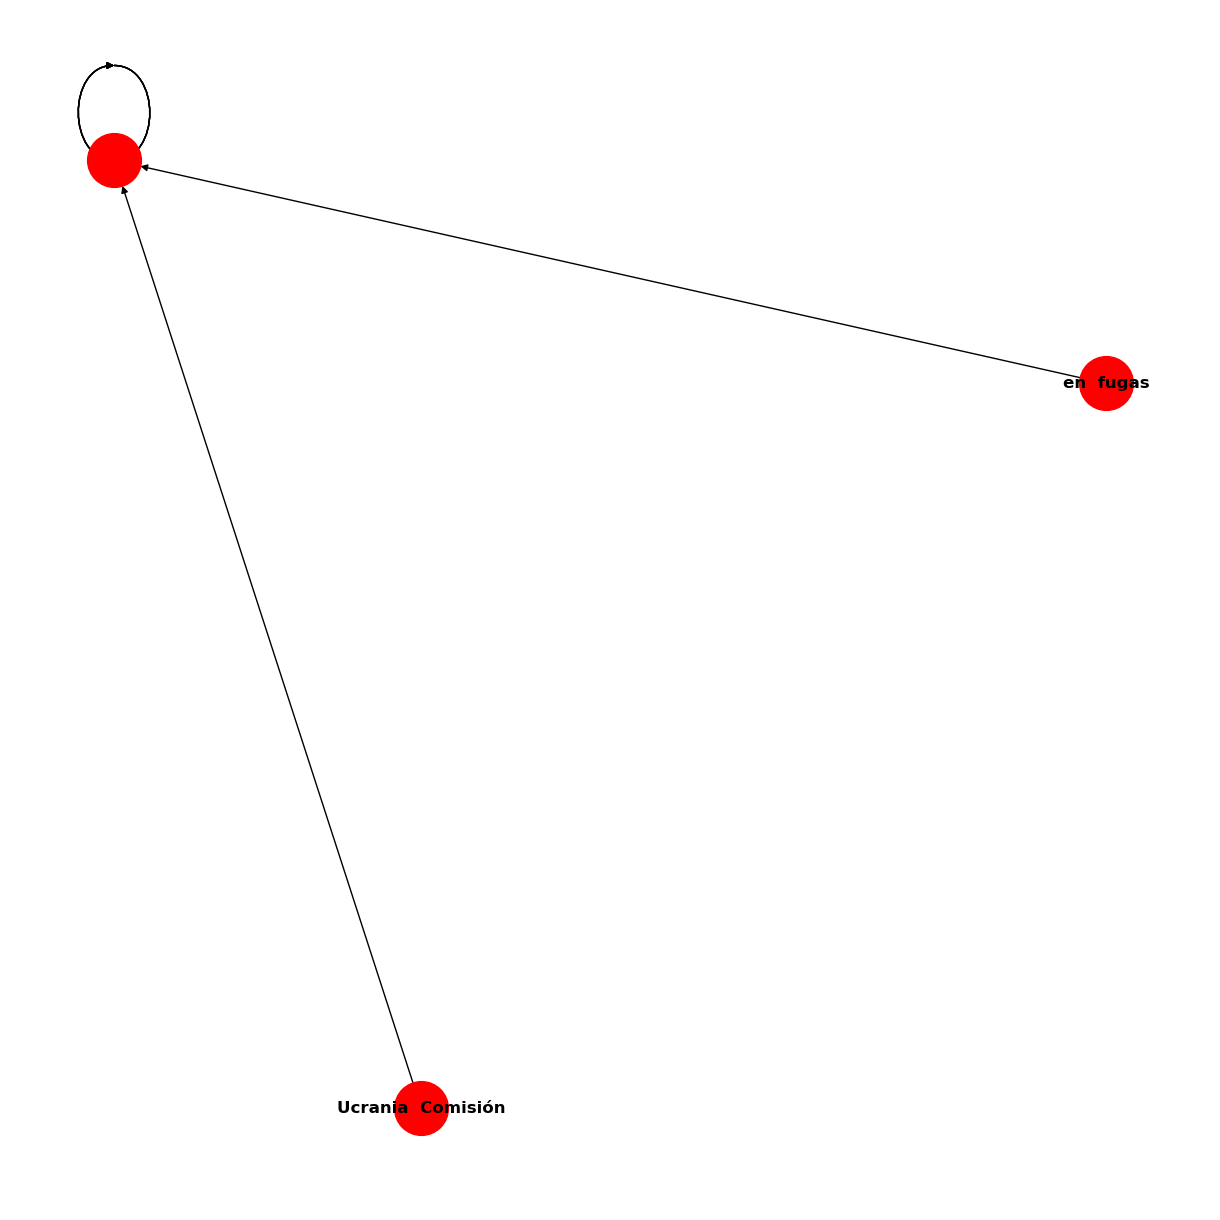

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Guerra"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
 
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()

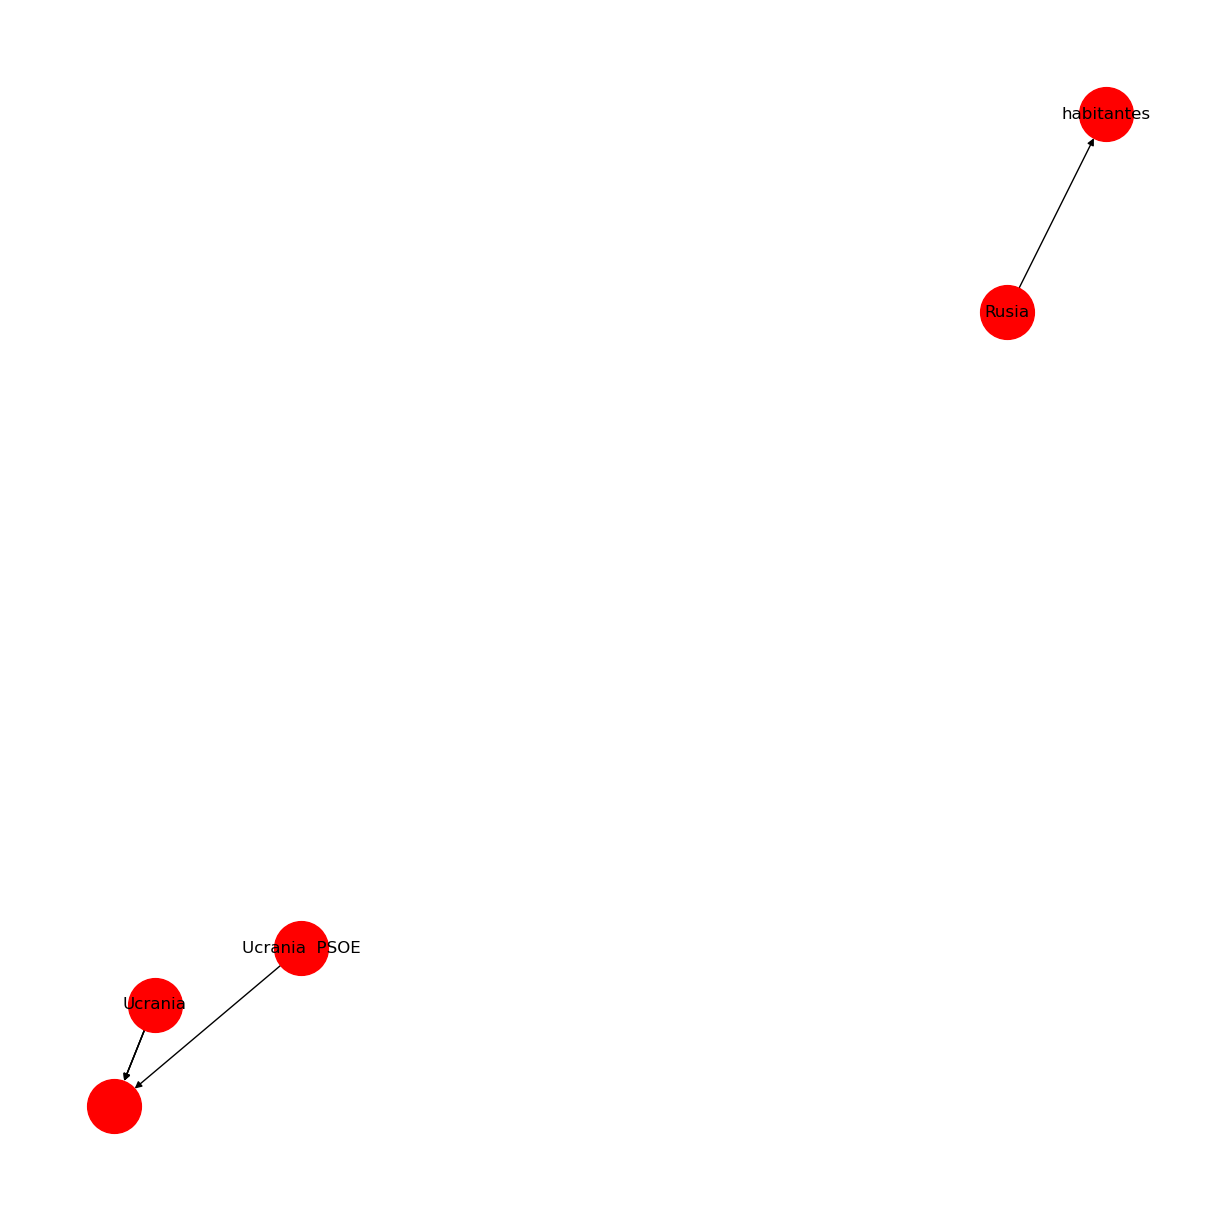

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="pide"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
 
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

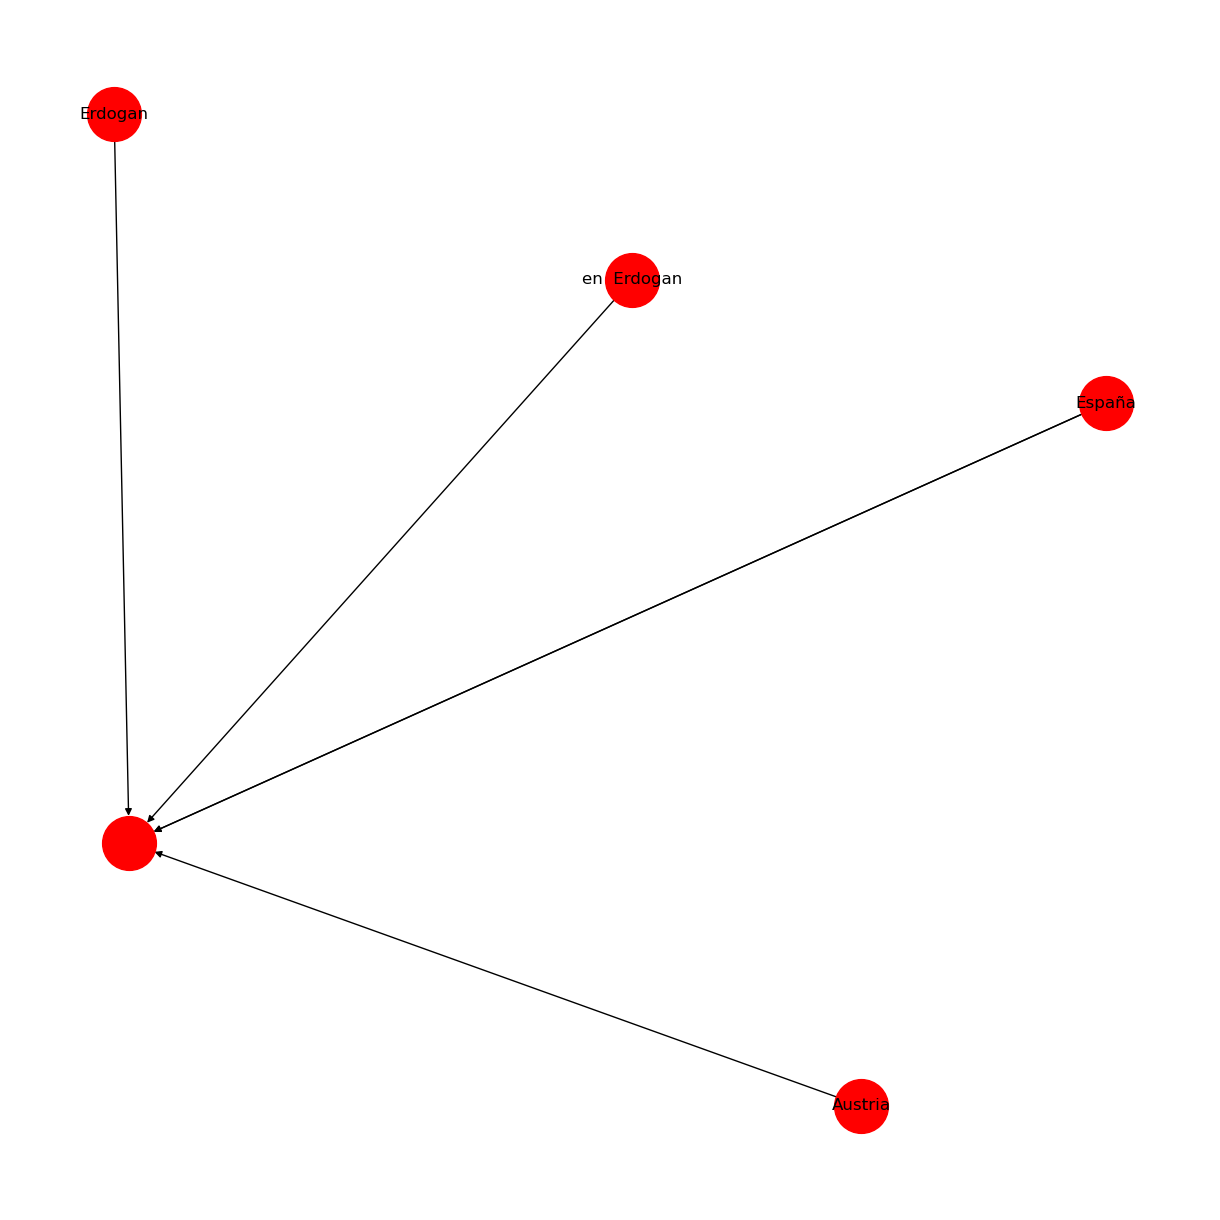

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="condena"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
 
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
kg_df.to_csv('export_kg.csv', index=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()